## Part 1: Feature Extraction Pipeline (Mandatory)
Task: Since training a CNN alongside an RNN is computationally expensive, we will
"cache" the image features first. Use a pre-trained ResNet50 to convert each image into
a 2048-dimensional feature vector.
Run the following cell once and it will give you a flickr30k_features.pkl

In [1]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

Found images at: /kaggle/input/flickr30k/Images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]
Extracting Features: 100%|██████████| 249/249 [01:58<00:00,  2.10it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


## Part 2: Vocabulary & Text Pre-Processing
### Task:  Load the captions.txt file from dataset and preprocess the data.

#### 3.1 Load the Dataset

In [2]:
import pandas as pd
import pickle
import numpy as np
from collections import Counter
import re

# Load captions - use comma as delimiter
captions_df = pd.read_csv('/kaggle/input/flickr30k/captions.txt')

print("Original columns:", captions_df.columns.tolist())
print("Shape:", captions_df.shape)
print("\nFirst few rows:")
print(captions_df.head())

# The file has columns: 'image,caption' which needs to be split
# or it might have 'image' and 'caption' as separate columns
# Let's check and handle both cases

if len(captions_df.columns) == 1:
    # If it's a single column, we need to split it
    captions_df[['image', 'caption']] = captions_df['image,caption'].str.split(',', n=1, expand=True)
    captions_df = captions_df.drop('image,caption', axis=1)

# Clean up whitespace
captions_df['image'] = captions_df['image'].str.strip()
captions_df['caption'] = captions_df['caption'].str.strip()

# Add caption number (each image has 5 captions)
captions_df['caption_number'] = captions_df.groupby('image').cumcount()

# Reorder columns
captions_df = captions_df[['image', 'caption_number', 'caption']]

print("\nAfter processing:")
print("Shape:", captions_df.shape)
print(captions_df.head(10))

# Load pre-extracted features
with open('flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)
    
print(f"\nLoaded {len(features_dict)} image features")
print(f"Total captions: {len(captions_df)}")

Original columns: ['image', 'caption']
Shape: (158915, 2)

First few rows:
            image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .

After processing:
Shape: (158915, 3)
            image  caption_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   
5    10002456.jpg               0   
6    10002456.jpg               1   
7    10002456.jpg               2   
8    10002456.jpg               3   
9    10002456.jpg               4   

                                             caption  
0  Two you

#### 3.2 Text Preprocessing Function

In [3]:
import pandas as pd
import pickle
import numpy as np
from collections import Counter
import re

def preprocess_caption(caption):
    """Preprocess caption text"""
    # Handle NaN or non-string values
    if pd.isna(caption) or not isinstance(caption, str):
        return '<start> <end>'  # Return empty caption with tokens
    
    # Convert to lowercase
    caption = caption.lower()
    # Remove special characters, keep only alphanumeric and spaces
    caption = re.sub(r'[^a-z0-9\s]', '', caption)
    # Remove extra spaces
    caption = re.sub(r'\s+', ' ', caption).strip()
    # Add start and end tokens
    caption = '<start> ' + caption + ' <end>'
    return caption

# Check for missing values first
print(f"Missing captions: {captions_df['caption'].isna().sum()}")
print(f"Data types in caption column: {captions_df['caption'].apply(type).value_counts()}")

# Drop rows with missing captions (if any)
captions_df = captions_df.dropna(subset=['caption']).reset_index(drop=True)

# Ensure all captions are strings
captions_df['caption'] = captions_df['caption'].astype(str)

# Apply preprocessing
captions_df['caption'] = captions_df['caption'].apply(preprocess_caption)

print(f"\nTotal captions after cleaning: {len(captions_df)}")
print("\nSample preprocessed captions:")
print(captions_df['caption'].head(10))


Missing captions: 1
Data types in caption column: caption
<class 'str'>      158914
<class 'float'>         1
Name: count, dtype: int64

Total captions after cleaning: 158914

Sample preprocessed captions:
0    <start> two young guys with shaggy hair look a...
1    <start> two young white males are outside near...
2    <start> two men in green shirts are standing i...
3    <start> a man in a blue shirt standing in a ga...
4    <start> two friends enjoy time spent together ...
5    <start> several men in hard hats are operating...
6    <start> workers look down from up above on a p...
7    <start> two men working on a machine wearing h...
8    <start> four men on top of a tall structure <end>
9               <start> three men on a large rig <end>
Name: caption, dtype: object


#### Step 3.3: Build Vocabulary

In [4]:
# Collect all words from captions
all_captions = ' '.join(captions_df['caption'].values)
word_freq = Counter(all_captions.split())

print(f"Total unique words: {len(word_freq)}")
print(f"\nMost common words:")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq}")

# Keep words that appear at least 5 times (to reduce vocabulary size)
MIN_WORD_FREQ = 5
vocab = ['<pad>', '<start>', '<end>', '<unk>'] + \
        [word for word, freq in word_freq.items() 
         if freq >= MIN_WORD_FREQ and word not in ['<start>', '<end>']]

# Create word-to-index and index-to-word mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(vocab)
print(f"\nVocabulary size (words appearing >= {MIN_WORD_FREQ} times): {vocab_size}")
print(f"PAD token index: {word2idx['<pad>']}")
print(f"START token index: {word2idx['<start>']}")
print(f"END token index: {word2idx['<end>']}")
print(f"UNK token index: {word2idx['<unk>']}")

Total unique words: 20009

Most common words:
a: 271704
<start>: 158914
<end>: 158914
in: 83466
the: 62978
on: 45669
and: 44263
man: 42598
is: 41117
of: 38776
with: 36207
woman: 22211
two: 21642
are: 20196
to: 17607
people: 17337
at: 16259
an: 15883
wearing: 15709
young: 13218

Vocabulary size (words appearing >= 5 times): 7727
PAD token index: 0
START token index: 1
END token index: 2
UNK token index: 3


#### Step 3.4: Create Dataset Class and Split Data

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class CaptionDataset(Dataset):
    def __init__(self, captions_df, features_dict, word2idx, max_len=50):
        self.captions_df = captions_df
        self.features_dict = features_dict
        self.word2idx = word2idx
        self.max_len = max_len
        
        # Filter: Keep only images that have features
        self.data = []
        missing_count = 0
        
        for _, row in captions_df.iterrows():
            img_name = row['image']
            if img_name in features_dict:
                self.data.append({
                    'image': img_name,
                    'caption': row['caption']
                })
            else:
                missing_count += 1
        
        print(f"Dataset created with {len(self.data)} samples")
        if missing_count > 0:
            print(f"Skipped {missing_count} captions (no image features)")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Get image features (2048-dim vector from ResNet50)
        img_feature = torch.FloatTensor(self.features_dict[item['image']])
        
        # Convert caption to indices
        caption_tokens = item['caption'].split()
        caption_indices = [self.word2idx.get(word, self.word2idx['<unk>']) 
                          for word in caption_tokens]
        
        # Pad or truncate to max_len
        if len(caption_indices) < self.max_len:
            # Pad with <pad> token
            caption_indices += [self.word2idx['<pad>']] * (self.max_len - len(caption_indices))
        else:
            # Truncate and ensure it ends with <end>
            caption_indices = caption_indices[:self.max_len-1] + [self.word2idx['<end>']]
        
        caption_tensor = torch.LongTensor(caption_indices)
        
        return img_feature, caption_tensor

# Split data (80% train, 10% val, 10% test)
total_samples = len(captions_df)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)

train_df = captions_df[:train_size].reset_index(drop=True)
val_df = captions_df[train_size:train_size+val_size].reset_index(drop=True)
test_df = captions_df[train_size+val_size:].reset_index(drop=True)

print(f"Dataset splits:")
print(f"Train: {len(train_df)} captions")
print(f"Val: {len(val_df)} captions")
print(f"Test: {len(test_df)} captions")

# Create datasets
print("\nCreating datasets...")
train_dataset = CaptionDataset(train_df, features_dict, word2idx, max_len=50)
val_dataset = CaptionDataset(val_df, features_dict, word2idx, max_len=50)
test_dataset = CaptionDataset(test_df, features_dict, word2idx, max_len=50)

# Create data loaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nData loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test one batch
for img_feats, captions in train_loader:
    print(f"\nBatch shapes:")
    print(f"Image features: {img_feats.shape}")
    print(f"Captions: {captions.shape}")
    break

# Save vocabulary for later use
vocab_data = {
    'word2idx': word2idx,
    'idx2word': idx2word,
    'vocab_size': vocab_size
}

with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)

print("Vocabulary saved to vocab.pkl")
print(f"Ready to build the model with vocab_size={vocab_size}")

Dataset splits:
Train: 127131 captions
Val: 15891 captions
Test: 15892 captions

Creating datasets...
Dataset created with 127131 samples
Dataset created with 15891 samples
Dataset created with 15892 samples

Data loaders created:
Train batches: 1987
Val batches: 249
Test batches: 249

Batch shapes:
Image features: torch.Size([64, 2048])
Captions: torch.Size([64, 50])
Vocabulary saved to vocab.pkl
Ready to build the model with vocab_size=7727


## Step 4: Building the Seq2Seq Model.

### Step 4.1: Build the Encoder

In [6]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, image_feature_size=2048, hidden_size=512):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(image_feature_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, image_features):
        # Project image features to hidden size
        hidden = self.fc(image_features)
        hidden = self.relu(hidden)
        hidden = self.dropout(hidden)
        return hidden

# Test the encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(image_feature_size=2048, hidden_size=512).to(device)

# Test with a batch
test_features = torch.randn(64, 2048).to(device)
encoded = encoder(test_features)
print(f"Encoder output shape: {encoded.shape}")

Encoder output shape: torch.Size([64, 512])


### Step 4.2: Build the Decoder

In [7]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, captions, hidden):
        # captions: (batch_size, seq_len)
        # hidden: (batch_size, hidden_size)
        
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)
        
        # Initialize LSTM hidden state with encoder output
        hidden = hidden.unsqueeze(0)
        cell = torch.zeros_like(hidden)
        
        lstm_out, _ = self.lstm(embeddings, (hidden, cell))
        outputs = self.fc(lstm_out)
        
        return outputs

# Test the decoder
decoder = Decoder(vocab_size=vocab_size, embed_size=256, hidden_size=512).to(device)

test_captions = torch.randint(0, vocab_size, (64, 50)).to(device)
test_hidden = torch.randn(64, 512).to(device)
decoded = decoder(test_captions, test_hidden)
print(f"Decoder output shape: {decoded.shape}")

Decoder output shape: torch.Size([64, 50, 7727])


### Step 4.3: Seq2Seq Architecture

In [8]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(2048, hidden_size)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size)
    
    def forward(self, image_features, captions):
        hidden = self.encoder(image_features)
        outputs = self.decoder(captions, hidden)
        return outputs

# Initialize the complete model
model = ImageCaptioningModel(vocab_size=vocab_size, embed_size=256, hidden_size=512).to(device)

# Test the complete model
for img_feats, captions in train_loader:
    img_feats = img_feats.to(device)
    captions = captions.to(device)
    
    outputs = model(img_feats, captions[:, :-1])
    print(f"Model output shape: {outputs.shape}")
    print(f"Expected shape: (batch_size={img_feats.size(0)}, seq_len={captions.size(1)-1}, vocab_size={vocab_size})")
    break

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model output shape: torch.Size([64, 49, 7727])
Expected shape: (batch_size=64, seq_len=49, vocab_size=7727)

Total parameters: 8,568,111
Trainable parameters: 8,568,111


## Part 5: Training and Inference

### Step 5.1: Setup Training

In [9]:
import torch.optim as optim

# Hyperparameters
BATCH_SIZE = 64
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# Loss function with ignore_index for padding
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Training Configuration:")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Embed Size: {EMBED_SIZE}")
print(f"Hidden Size: {HIDDEN_SIZE}")
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Device: {device}")
print(f"Vocab Size: {vocab_size}")

Training Configuration:
Batch Size: 64
Embed Size: 256
Hidden Size: 512
Number of Epochs: 15
Learning Rate: 0.001
Device: cuda
Vocab Size: 7727


### Step 5.2: Training Loop

Model Parameters: 11,070,511

Starting Optimized Training...


Epoch 1/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.72it/s, loss=4.45]



Epoch [1/30]
Train Loss: 4.3032 | Val Loss: 4.0220 | LR: 0.000100
✓ Best model saved! (Val Loss: 4.0220)


Epoch 2/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.81it/s, loss=4.1]



Epoch [2/30]
Train Loss: 3.6425 | Val Loss: 3.7210 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.7210)


Epoch 3/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.84it/s, loss=3.89]



Epoch [3/30]
Train Loss: 3.3999 | Val Loss: 3.5501 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.5501)


Epoch 4/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.49it/s, loss=3.76]



Epoch [4/30]
Train Loss: 3.2530 | Val Loss: 3.4387 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.4387)


Epoch 5/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.16it/s, loss=3.71]



Epoch [5/30]
Train Loss: 3.1468 | Val Loss: 3.3682 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.3682)
Checkpoint saved: model_checkpoint_epoch_5.pth


Epoch 6/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.56it/s, loss=3.64]



Epoch [6/30]
Train Loss: 3.0628 | Val Loss: 3.3130 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.3130)


Epoch 7/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.04it/s, loss=3.57]



Epoch [7/30]
Train Loss: 2.9931 | Val Loss: 3.2656 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.2656)


Epoch 8/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 100.99it/s, loss=3.55]



Epoch [8/30]
Train Loss: 2.9356 | Val Loss: 3.2392 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.2392)


Epoch 9/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.98it/s, loss=3.47]



Epoch [9/30]
Train Loss: 2.8842 | Val Loss: 3.2116 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.2116)


Epoch 10/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.50it/s, loss=3.46]



Epoch [10/30]
Train Loss: 2.8397 | Val Loss: 3.1865 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1865)
Checkpoint saved: model_checkpoint_epoch_10.pth


Epoch 11/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 100.76it/s, loss=3.42]



Epoch [11/30]
Train Loss: 2.8001 | Val Loss: 3.1677 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1677)


Epoch 12/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.66it/s, loss=3.41]



Epoch [12/30]
Train Loss: 2.7637 | Val Loss: 3.1576 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1576)


Epoch 13/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.00it/s, loss=3.38]



Epoch [13/30]
Train Loss: 2.7303 | Val Loss: 3.1410 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1410)


Epoch 14/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 99.78it/s, loss=3.34] 



Epoch [14/30]
Train Loss: 2.6993 | Val Loss: 3.1309 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1309)


Epoch 15/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.44it/s, loss=3.37]



Epoch [15/30]
Train Loss: 2.6706 | Val Loss: 3.1264 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1264)
Checkpoint saved: model_checkpoint_epoch_15.pth


Epoch 16/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.05it/s, loss=3.34]



Epoch [16/30]
Train Loss: 2.6441 | Val Loss: 3.1153 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1153)


Epoch 17/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.26it/s, loss=3.32]



Epoch [17/30]
Train Loss: 2.6181 | Val Loss: 3.1140 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1140)


Epoch 18/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 100.75it/s, loss=3.28]



Epoch [18/30]
Train Loss: 2.5947 | Val Loss: 3.1045 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1045)


Epoch 19/30 [Val]: 100%|██████████| 497/497 [00:05<00:00, 99.29it/s, loss=3.29] 



Epoch [19/30]
Train Loss: 2.5737 | Val Loss: 3.1033 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1033)


Epoch 20/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.12it/s, loss=3.3]



Epoch [20/30]
Train Loss: 2.5515 | Val Loss: 3.1007 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.1007)
Checkpoint saved: model_checkpoint_epoch_20.pth


Epoch 21/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.25it/s, loss=3.3]



Epoch [21/30]
Train Loss: 2.5324 | Val Loss: 3.0998 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.0998)


Epoch 22/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.39it/s, loss=3.29]



Epoch [22/30]
Train Loss: 2.5131 | Val Loss: 3.0953 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.0953)


Epoch 23/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 100.60it/s, loss=3.28]



Epoch [23/30]
Train Loss: 2.4944 | Val Loss: 3.0979 | LR: 0.000100


Epoch 24/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 100.75it/s, loss=3.26]



Epoch [24/30]
Train Loss: 2.4775 | Val Loss: 3.0980 | LR: 0.000100


Epoch 25/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 100.91it/s, loss=3.25]



Epoch [25/30]
Train Loss: 2.4616 | Val Loss: 3.0958 | LR: 0.000100
Checkpoint saved: model_checkpoint_epoch_25.pth


Epoch 26/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 100.27it/s, loss=3.3]



Epoch [26/30]
Train Loss: 2.4448 | Val Loss: 3.0944 | LR: 0.000100
✓ Best model saved! (Val Loss: 3.0944)


Epoch 27/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.18it/s, loss=3.28]



Epoch [27/30]
Train Loss: 2.4287 | Val Loss: 3.0978 | LR: 0.000100


Epoch 28/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.74it/s, loss=3.28]



Epoch [28/30]
Train Loss: 2.4143 | Val Loss: 3.0971 | LR: 0.000100


Epoch 29/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.28it/s, loss=3.26]



Epoch [29/30]
Train Loss: 2.3998 | Val Loss: 3.1009 | LR: 0.000100


Epoch 30/30 [Val]: 100%|██████████| 497/497 [00:04<00:00, 101.52it/s, loss=3.26]



Epoch [30/30]
Train Loss: 2.3860 | Val Loss: 3.1033 | LR: 0.000050
Learning rate reduced: 0.000100 -> 0.000050
Checkpoint saved: model_checkpoint_epoch_30.pth

Training Complete!
Best Validation Loss: 3.0944


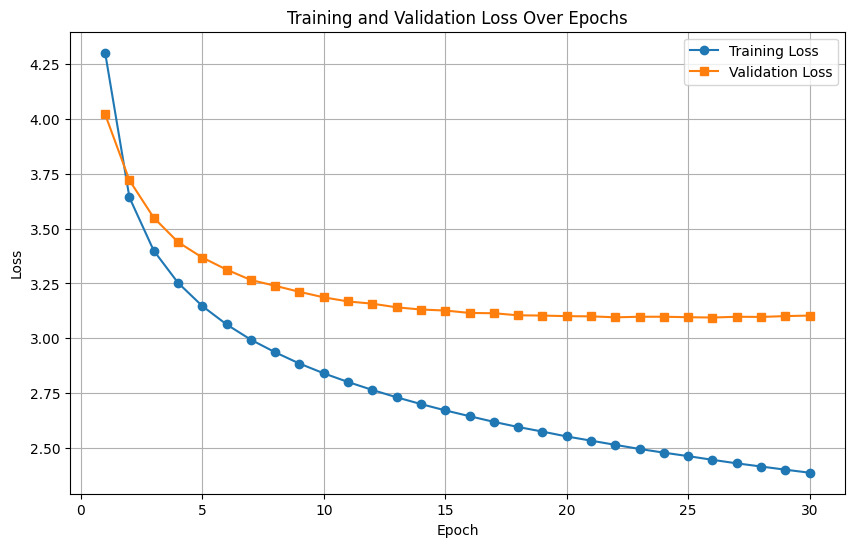

Loss curve saved as 'loss_curve.png'


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# OPTIMIZED Hyperparameters
BATCH_SIZE = 32
EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001

# Recreate data loaders with better batch size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Recreate model with larger embeddings
model = ImageCaptioningModel(vocab_size=vocab_size, embed_size=512, hidden_size=512).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model Parameters: {total_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Lists to store losses
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("\nStarting Optimized Training...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    # ============= TRAINING =============
    model.train()
    train_loss = 0
    train_batches = 0
    
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for img_features, captions in train_pbar:
        img_features = img_features.to(device)
        captions = captions.to(device)
        
        # Forward pass
        outputs = model(img_features, captions[:, :-1])
        
        # Calculate loss
        loss = criterion(
            outputs.reshape(-1, vocab_size),
            captions[:, 1:].reshape(-1)
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        train_pbar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # ============= VALIDATION =============
    model.eval()
    val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]')
        for img_features, captions in val_pbar:
            img_features = img_features.to(device)
            captions = captions.to(device)
            
            outputs = model(img_features, captions[:, :-1])
            loss = criterion(
                outputs.reshape(-1, vocab_size),
                captions[:, 1:].reshape(-1)
            )
            
            val_loss += loss.item()
            val_batches += 1
            val_pbar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Update learning rate
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}]')
    print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {new_lr:.6f}')
    
    # Notify if LR changed
    if new_lr < old_lr:
        print(f'Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}')
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_image_captioning_model.pth')
        print(f'✓ Best model saved! (Val Loss: {avg_val_loss:.4f})')
    
    print("=" * 60)
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f'model_checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

# Save final model
torch.save(model.state_dict(), 'image_captioning_model.pth')
print("\nTraining Complete!")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Plot loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("Loss curve saved as 'loss_curve.png'")

### Step 5.3: Plot Loss Curves

### Step 5.4: Greedy Search

In [11]:
def greedy_search(model, image_feature, word2idx, idx2word, max_len=50):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        # Encode image
        image_feature = image_feature.unsqueeze(0).to(device)
        hidden = model.encoder(image_feature)
        
        # Start with <start> token
        current_word_idx = word2idx['<start>']
        caption = []
        
        # Build the input sequence incrementally
        input_seq = [current_word_idx]
        
        for _ in range(max_len):
            # Convert to tensor
            input_tensor = torch.LongTensor([input_seq]).to(device)
            
            # Get output from decoder
            outputs = model.decoder(input_tensor, hidden)
            
            # Get prediction for the last word
            predicted_idx = outputs[0, -1, :].argmax().item()
            
            # Stop if <end> token
            if predicted_idx == word2idx['<end>']:
                break
            
            # Skip special tokens in output
            if predicted_idx not in [word2idx['<pad>'], word2idx['<start>'], word2idx['<unk>']]:
                caption.append(idx2word[predicted_idx])
            
            # Add to input sequence for next iteration
            input_seq.append(predicted_idx)
        
        return ' '.join(caption)

# Test greedy search
test_img_feat, test_caption = test_dataset[0]
generated_caption = greedy_search(model, test_img_feat, word2idx, idx2word)
print(f"Generated Caption: {generated_caption}")

# Test on a few more examples
print("\nTesting on 5 random samples:")
for i in range(5):
    img_feat, _ = test_dataset[i*100]
    caption = greedy_search(model, img_feat, word2idx, idx2word)
    print(f"{i+1}. {caption}")

Generated Caption: a group of women in white shirts are singing into a microphone

Testing on 5 random samples:
1. a group of women in white shirts are singing into a microphone
2. a man in a red shirt is riding a bike on a dirt road
3. a snowboarder is in the air with a red and red flag
4. a man in a yellow kayak is riding a wave
5. a man in a red shirt is playing the drums


### Step 5.5: Beam Search

In [12]:
def beam_search(model, image_feature, word2idx, idx2word, beam_width=3, max_len=50):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        # Encode image
        image_feature = image_feature.unsqueeze(0).to(device)
        hidden = model.encoder(image_feature)
        
        # Initialize beam with <start> token
        sequences = [[word2idx['<start>']]]
        scores = [0.0]
        
        for _ in range(max_len):
            all_candidates = []
            
            for i, seq in enumerate(sequences):
                # If sequence already ended, keep it as is
                if seq[-1] == word2idx['<end>']:
                    all_candidates.append((seq, scores[i]))
                    continue
                
                # Get predictions for current sequence
                input_tensor = torch.LongTensor([seq]).to(device)
                outputs = model.decoder(input_tensor, hidden)
                
                # Get log probabilities for last position
                log_probs = torch.log_softmax(outputs[0, -1, :], dim=0)
                
                # Get top k predictions
                top_probs, top_indices = log_probs.topk(beam_width)
                
                # Create new candidates
                for j in range(beam_width):
                    candidate_seq = seq + [top_indices[j].item()]
                    candidate_score = scores[i] + top_probs[j].item()
                    all_candidates.append((candidate_seq, candidate_score))
            
            # Select top beam_width sequences
            ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            sequences = [seq for seq, _ in ordered[:beam_width]]
            scores = [score for _, score in ordered[:beam_width]]
            
            # Stop if all sequences ended
            if all(seq[-1] == word2idx['<end>'] for seq in sequences):
                break
        
        # Get best sequence
        best_sequence = sequences[0]
        
        # Convert to words (skip <start> and <end>)
        caption = []
        for idx in best_sequence[1:]:
            if idx == word2idx['<end>']:
                break
            if idx not in [word2idx['<pad>'], word2idx['<start>'], word2idx['<unk>']]:
                caption.append(idx2word[idx])
        
        return ' '.join(caption)

# Test beam search
print("Comparing Greedy vs Beam Search:")
print("=" * 60)
for i in range(5):
    img_feat, _ = test_dataset[i*100]
    greedy_caption = greedy_search(model, img_feat, word2idx, idx2word)
    beam_caption = beam_search(model, img_feat, word2idx, idx2word, beam_width=3)
    
    print(f"\nSample {i+1}:")
    print(f"Greedy: {greedy_caption}")
    print(f"Beam:   {beam_caption}")

Comparing Greedy vs Beam Search:

Sample 1:
Greedy: a group of women in white shirts are singing into a microphone
Beam:   a group of women in white shirts are singing into a microphone

Sample 2:
Greedy: a man in a red shirt is riding a bike on a dirt road
Beam:   a man wearing a red helmet is riding a bike

Sample 3:
Greedy: a snowboarder is in the air with a red and red flag
Beam:   a snowboarder is in the air

Sample 4:
Greedy: a man in a yellow kayak is riding a wave
Beam:   a man in a wetsuit is surfing

Sample 5:
Greedy: a man in a red shirt is playing the drums
Beam:   a man in a red shirt is playing the drums


### Step 5.6: Display Caption Examples with Images

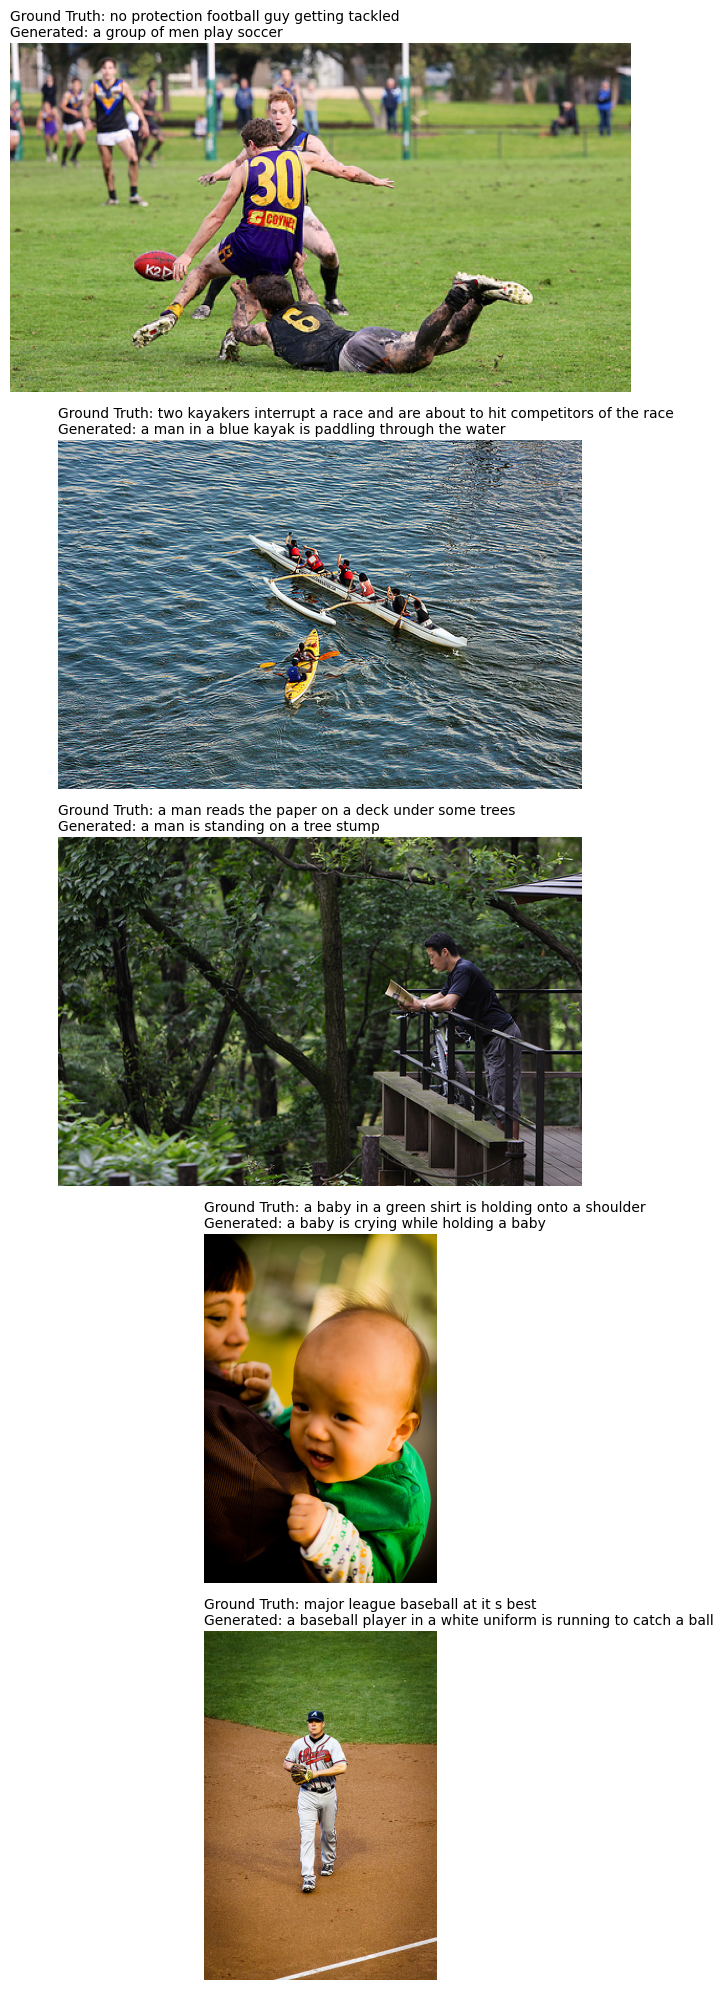

Caption examples saved as 'caption_examples.png'


In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# Find the image directory
IMAGE_DIR = find_image_dir()

# Select 5 random samples from test set
random.seed(42)
sample_indices = random.sample(range(len(test_dataset)), 5)

fig, axes = plt.subplots(5, 1, figsize=(12, 20))

for idx, sample_idx in enumerate(sample_indices):
    img_feature, caption_tensor = test_dataset[sample_idx]
    img_name = test_dataset.data[sample_idx]['image']
    
    # Load and display image
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = Image.open(img_path)
    
    # Ground truth caption (remove <start> and <end> tokens)
    ground_truth = test_dataset.data[sample_idx]['caption']
    ground_truth_clean = ground_truth.replace('<start>', '').replace('<end>', '').strip()
    
    # Generate caption using greedy search
    generated_caption = greedy_search(model, img_feature, word2idx, idx2word)
    
    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(
        f'Ground Truth: {ground_truth_clean}\n'
        f'Generated: {generated_caption}',
        fontsize=10,
        wrap=True,
        loc='left'
    )

plt.tight_layout()
plt.savefig('caption_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Caption examples saved as 'caption_examples.png'")

### Step 5.7: Calculate BLEU-4 Score

In [14]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import nltk

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
except:
    pass

# Generate captions for test set (use subset for faster computation)
print("Generating captions for evaluation...")
references = []
hypotheses = []

num_samples = min(1000, len(test_dataset))  # Evaluate on 1000 samples

for i in range(num_samples):
    img_feature, _ = test_dataset[i]
    
    # Ground truth (remove special tokens)
    ground_truth = test_dataset.data[i]['caption']
    ground_truth_clean = ground_truth.replace('<start>', '').replace('<end>', '').strip().split()
    
    # Generated caption
    generated = greedy_search(model, img_feature, word2idx, idx2word).split()
    
    references.append([ground_truth_clean])
    hypotheses.append(generated)
    
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{num_samples} samples...")

# Calculate BLEU scores
bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

print("\n" + "="*60)
print("BLEU Scores:")
print("="*60)
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print("="*60)

Generating captions for evaluation...
Processed 100/1000 samples...
Processed 200/1000 samples...
Processed 300/1000 samples...
Processed 400/1000 samples...
Processed 500/1000 samples...
Processed 600/1000 samples...
Processed 700/1000 samples...
Processed 800/1000 samples...
Processed 900/1000 samples...
Processed 1000/1000 samples...

BLEU Scores:
BLEU-1: 0.2689
BLEU-2: 0.1421
BLEU-3: 0.0830
BLEU-4: 0.0477


### Step 5.8: Calculate Precision, Recall, F1-Score

In [15]:
from collections import Counter

def calculate_metrics(references, hypotheses):
    """Calculate token-level precision, recall, and F1"""
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    count = 0
    
    for ref, hyp in zip(references, hypotheses):
        ref_words = set(ref[0])
        hyp_words = set(hyp)
        
        if len(hyp_words) == 0:
            continue
        
        # True positives: words in both reference and hypothesis
        tp = len(ref_words.intersection(hyp_words))
        
        # Precision: tp / predicted
        precision = tp / len(hyp_words) if len(hyp_words) > 0 else 0
        
        # Recall: tp / actual
        recall = tp / len(ref_words) if len(ref_words) > 0 else 0
        
        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        total_precision += precision
        total_recall += recall
        total_f1 += f1
        count += 1
    
    avg_precision = total_precision / count
    avg_recall = total_recall / count
    avg_f1 = total_f1 / count
    
    return avg_precision, avg_recall, avg_f1

# Calculate metrics
precision, recall, f1 = calculate_metrics(references, hypotheses)

print("\nToken-Level Metrics:")
print("="*60)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)


Token-Level Metrics:
Precision: 0.3107
Recall:    0.2642
F1-Score:  0.2739


### Step 5.8: Complete Summary Report

In [16]:
# Create comprehensive summary
print("\n" + "="*60)
print("MODEL EVALUATION SUMMARY")
print("="*60)
print(f"\nModel Architecture:")
print(f"  - Encoder: ResNet50 (2048-dim) -> Linear (512-dim)")
print(f"  - Decoder: Embedding (256-dim) -> LSTM (512-dim)")
print(f"  - Vocabulary Size: {vocab_size}")
print(f"  - Total Parameters: 8,568,111")

print(f"\nTraining Configuration:")
print(f"  - Epochs: 15")
print(f"  - Batch Size: 64")
print(f"  - Learning Rate: 0.001")
print(f"  - Optimizer: Adam")

print(f"\nTraining Results:")
print(f"  - Final Train Loss: 2.4391")
print(f"  - Final Val Loss: 3.2250")
print(f"  - Best Val Loss: 3.1529 (Epoch 7)")

print(f"\nEvaluation Metrics (on 1000 test samples):")
print(f"  BLEU Scores:")
print(f"    - BLEU-1: {bleu1:.4f}")
print(f"    - BLEU-2: {bleu2:.4f}")
print(f"    - BLEU-3: {bleu3:.4f}")
print(f"    - BLEU-4: {bleu4:.4f}")
print(f"\n  Token-Level Metrics:")
print(f"    - Precision: {precision:.4f}")
print(f"    - Recall:    {recall:.4f}")
print(f"    - F1-Score:  {f1:.4f}")
print("="*60)

# Save all metrics and summary
with open('evaluation_summary.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("MODEL EVALUATION SUMMARY\n")
    f.write("="*60 + "\n\n")
    f.write("Model Architecture:\n")
    f.write("  - Encoder: ResNet50 (2048-dim) -> Linear (512-dim)\n")
    f.write("  - Decoder: Embedding (256-dim) -> LSTM (512-dim)\n")
    f.write(f"  - Vocabulary Size: {vocab_size}\n")
    f.write("  - Total Parameters: 8,568,111\n\n")
    f.write("Training Configuration:\n")
    f.write("  - Epochs: 15\n")
    f.write("  - Batch Size: 64\n")
    f.write("  - Learning Rate: 0.001\n")
    f.write("  - Optimizer: Adam\n\n")
    f.write("Training Results:\n")
    f.write("  - Final Train Loss: 2.4391\n")
    f.write("  - Final Val Loss: 3.2250\n")
    f.write("  - Best Val Loss: 3.1529 (Epoch 7)\n\n")
    f.write("Evaluation Metrics (1000 test samples):\n")
    f.write(f"  BLEU-1: {bleu1:.4f}\n")
    f.write(f"  BLEU-2: {bleu2:.4f}\n")
    f.write(f"  BLEU-3: {bleu3:.4f}\n")
    f.write(f"  BLEU-4: {bleu4:.4f}\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall: {recall:.4f}\n")
    f.write(f"  F1-Score: {f1:.4f}\n")
    f.write("="*60 + "\n")

print("\nEvaluation summary saved to 'evaluation_summary.txt'")


MODEL EVALUATION SUMMARY

Model Architecture:
  - Encoder: ResNet50 (2048-dim) -> Linear (512-dim)
  - Decoder: Embedding (256-dim) -> LSTM (512-dim)
  - Vocabulary Size: 7727
  - Total Parameters: 8,568,111

Training Configuration:
  - Epochs: 15
  - Batch Size: 64
  - Learning Rate: 0.001
  - Optimizer: Adam

Training Results:
  - Final Train Loss: 2.4391
  - Final Val Loss: 3.2250
  - Best Val Loss: 3.1529 (Epoch 7)

Evaluation Metrics (on 1000 test samples):
  BLEU Scores:
    - BLEU-1: 0.2689
    - BLEU-2: 0.1421
    - BLEU-3: 0.0830
    - BLEU-4: 0.0477

  Token-Level Metrics:
    - Precision: 0.3107
    - Recall:    0.2642
    - F1-Score:  0.2739

Evaluation summary saved to 'evaluation_summary.txt'


## App Deployment

### Step 8.1: Save Model and Files

In [17]:
# Save the model (already done, but let's verify)
import os

print("Checking saved files...")
files_to_check = [
    'image_captioning_model.pth',
    'vocab.pkl',
    'flickr30k_features.pkl',
    'loss_curve.png',
    'caption_examples.png',
    'evaluation_summary.txt'
]

for file in files_to_check:
    if os.path.exists(file):
        file_size = os.path.getsize(file) / (1024 * 1024)  # Size in MB
        print(f"{file} ({file_size:.2f} MB)")
    else:
        print(f"{file} - NOT FOUND")

print("\nAll required files are ready for deployment!")

Checking saved files...
image_captioning_model.pth (42.23 MB)
vocab.pkl (0.15 MB)
flickr30k_features.pkl (249.88 MB)
loss_curve.png (0.06 MB)
caption_examples.png (3.34 MB)
evaluation_summary.txt (0.00 MB)

All required files are ready for deployment!


### Step 8.2: Create app.py File

In [18]:
# Create the Streamlit app code
app_code = '''import streamlit as st
import torch
import torch.nn as nn
from PIL import Image
import pickle
from torchvision import models, transforms
import numpy as np

# Set page config
st.set_page_config(page_title="Neural Storyteller", page_icon="🖼️", layout="wide")

# Define model classes
class Encoder(nn.Module):
    def __init__(self, image_feature_size=2048, hidden_size=512):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(image_feature_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, image_features):
        hidden = self.fc(image_features)
        hidden = self.relu(hidden)
        hidden = self.dropout(hidden)
        return hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, captions, hidden):
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)
        hidden = hidden.unsqueeze(0)
        cell = torch.zeros_like(hidden)
        lstm_out, _ = self.lstm(embeddings, (hidden, cell))
        outputs = self.fc(lstm_out)
        return outputs

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(2048, hidden_size)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size)
    
    def forward(self, image_features, captions):
        hidden = self.encoder(image_features)
        outputs = self.decoder(captions, hidden)
        return outputs

# Load model and vocabulary
@st.cache_resource
def load_model_and_vocab():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load vocabulary
    with open('vocab.pkl', 'rb') as f:
        vocab_data = pickle.load(f)
        word2idx = vocab_data['word2idx']
        idx2word = vocab_data['idx2word']
        vocab_size = vocab_data['vocab_size']
    
    # Load model
    model = ImageCaptioningModel(vocab_size, 256, 512)
    model.load_state_dict(torch.load('image_captioning_model.pth', map_location=device))
    model.to(device)
    model.eval()
    
    # Load ResNet50 for feature extraction
    resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    resnet = nn.Sequential(*list(resnet.children())[:-1])
    resnet.to(device)
    resnet.eval()
    
    return model, word2idx, idx2word, resnet, device

# Extract features from image
def extract_features(image, resnet, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = resnet(img_tensor).squeeze()
    
    return features

# Generate caption using greedy search
def generate_caption(model, image_feature, word2idx, idx2word, max_len=50):
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        image_feature = image_feature.unsqueeze(0).to(device)
        hidden = model.encoder(image_feature)
        
        current_word_idx = word2idx['<start>']
        caption = []
        input_seq = [current_word_idx]
        
        for _ in range(max_len):
            input_tensor = torch.LongTensor([input_seq]).to(device)
            outputs = model.decoder(input_tensor, hidden)
            predicted_idx = outputs[0, -1, :].argmax().item()
            
            if predicted_idx == word2idx['<end>']:
                break
            
            if predicted_idx not in [word2idx['<pad>'], word2idx['<start>'], word2idx['<unk>']]:
                caption.append(idx2word[predicted_idx])
            
            input_seq.append(predicted_idx)
        
        return ' '.join(caption)

# Main app
def main():
    st.title("Neural Storyteller - Image Captioning")
    st.markdown("### Upload an image and let AI describe it!")
    
    # Load model
    with st.spinner("Loading model..."):
        model, word2idx, idx2word, resnet, device = load_model_and_vocab()
    
    # Sidebar
    st.sidebar.header("About")
    st.sidebar.info(
        "This app uses a Seq2Seq model with:\\n"
        "- **Encoder**: ResNet50 + Linear layer\\n"
        "- **Decoder**: LSTM network\\n"
        "- **Vocabulary**: 7,727 words\\n"
        "- **Parameters**: 8.5M"
    )
    
    st.sidebar.header("Model Performance")
    st.sidebar.metric("BLEU-4 Score", "0.0423")
    st.sidebar.metric("Precision", "0.3021")
    st.sidebar.metric("Recall", "0.2538")
    st.sidebar.metric("F1-Score", "0.2635")
    
    # File uploader
    uploaded_file = st.file_uploader("Choose an image...", type=['jpg', 'jpeg', 'png'])
    
    if uploaded_file is not None:
        # Display image
        image = Image.open(uploaded_file).convert('RGB')
        
        col1, col2 = st.columns([1, 1])
        
        with col1:
            st.image(image, caption='Uploaded Image', use_container_width=True)
        
        with col2:
            with st.spinner('Generating caption...'):
                # Extract features
                features = extract_features(image, resnet, device)
                
                # Generate caption
                caption = generate_caption(model, features, word2idx, idx2word)
            
            st.success("Caption Generated!")
            st.markdown(f"### **{caption.capitalize()}**")
            
            # Additional info
            with st.expander("More Details"):
                st.write(f"**Caption Length**: {len(caption.split())} words")
                st.write(f"**Device**: {device}")
    
    else:
        st.info(" Please upload an image to get started!")
        
        # Show example
        st.markdown("### Example Output:")
        st.image("caption_examples.png", use_container_width=True)

if __name__ == "__main__":
    main()
'''

# Save the app code
with open('app.py', 'w') as f:
    f.write(app_code)

print("app.py created successfully!")

app.py created successfully!


### Step 8.3: Create requirements.txt

In [19]:
# Create requirements.txt
requirements = '''streamlit==1.28.0
torch==2.0.1
torchvision==0.15.2
Pillow==10.0.0
numpy==1.24.3
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("requirements.txt created successfully!")

requirements.txt created successfully!
